In [ ]:
%matplotlib inline
import os
import json
import pandas as pd
import numpy as np
import math
import altair as alt
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import cluster
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
import os
from folium import IFrame
from numpy import linalg
import scipy
import branca.colormap as cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
import itertools
world_geo = r"world.json" # geojson file

# enable correct rendering
alt.renderers.enable('default')
# uses intermediate json files to speed things up
alt.data_transformers.enable('json')


DataTransformerRegistry.enable('json')

In [ ]:
#Importing Main Dataset
df = pd.read_csv('data2.csv', encoding='latin1')
df.head(5)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

In [ ]:

#Dataframe Cleanup
#Stockcode which contains only digits signifies sale entry
#Hence we will filter out enteries with digit only stockcode

#Carriage did not drop, also look for returns if the qt. is negative and if they have same invoiceid 

clean_df = df[df.StockCode.str.contains('^\d', regex=True, na=False)]

# Drop quantities which are negative 
clean_df = clean_df[clean_df["Quantity"] >= 0]

#Adding SalesValue column to the Dataframe
clean_df["SalesValue"] = clean_df["Quantity"]*clean_df["UnitPrice"]

#UK Dataframe
uk_df = clean_df[clean_df['Country'] == 'United Kingdom']

#Rest of the World Dataframe
row_df = clean_df.drop(clean_df[clean_df['Country'] == 'United Kingdom'].index)

In [ ]:
#Grouping sales by customers
customer_df = clean_df.groupby(by=['CustomerID']).agg({'Quantity':['min', 'max', 'sum'], 'UnitPrice':['min', 'max', 'sum']})
print("Number of unique customers = ", customer_df.index.size)

Number of unique customers =  4335


In [ ]:
# Importing Secondary Datasets - Records for year range 2007 to 2011
# HDI could be additional variable
# Smartphone penetration dataset if available
# Credit card 

#Purchasing power parity GDP, PPP (constant 2017 international $) | Data (worldbank.org)
gdp_df = pd.read_excel('API_NY.GDP.MKTP.PP.KD_DS2_en_excel_v2_2764839.xls', 
                       sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

#Inflation CPI Consumer price index (2010 = 100) | Data (worldbank.org)
cpi_df = pd.read_excel("API_FP.CPI.TOTL_DS2_en_excel_v2_2765329.xls",
                       sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

#Debt % versus GDP External debt stocks, long-term (DOD, current US$) | Data (worldbank.org)
#extdebt_df = pd.read_excel("API_DT.DOD.DLXF.CD_DS2_en_excel_v2_2823747.xls",
#                           sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

#Individuals using the Internet (% of population) 

internet_df = pd.read_excel("API_IT.NET.USER.ZS_DS2_en_excel_v2_2764008.xls",
                    sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

#Exchange rate fluctuation (L5Y) Official exchange rate (LCU per US$, period average) | Data (worldbank.org)
exchrate_df = pd.read_excel("API_PA.NUS.FCRF_DS2_en_excel_v2_2764464.xls",
                            sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

#Population Population, total | Data (worldbank.org)
pop_df = pd.read_excel("API_SP.POP.TOTL_DS2_en_excel_v2_2764317.xls",
                       sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

#Merchandise imports Merchandise imports (current US$) | Data (worldbank.org)
merch_df = pd.read_excel("API_TM.VAL.MRCH.CD.WT_DS2_en_excel_v2_2766285.xls",
                         sheet_name=0, header=3, usecols="A,B,D,AZ:BD")
## new dataset 
expendHealth_df = pd.read_excel("Expenditure_on_health.xls",
                         sheet_name=0, header=3, usecols="A,B,D,AZ:BD")
## new dataset
lifeExpect_df = pd.read_excel("Life_expectancy.xls",
                         sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

## new dataset
PPP_per_capita_df = pd.read_excel("PPP_per_capita.xls",
                         sheet_name=0, header=3, usecols="A,B,D,AZ:BD")

#CERDI Sea Distance Dataset
seadist_df = pd.read_excel("CERDI-seadistance.xlsx", usecols="A,B,C")

# Cleaning Sea Distance DF to only include entries with UK as the origin
seadist_df = seadist_df[seadist_df["iso1"]=="GBR"]

## Importing region groups
regions = pd.read_excel("PPP_per_capita.xls",
                         sheet_name="Metadata - Countries", usecols="A,B,C")


In [ ]:
regions.columns=["code","region","incomeGroup"]
regions.columns

Index(['code', 'region', 'incomeGroup'], dtype='object')

In [ ]:
# Function to normalize country names to code that will be used as a key to combine all datasets
def valeurs(k,value=True):
    filtered={'United Kingdom': 'GBR',
 'France': 'FRA',
 'USA': 'USA',
 'Belgium': 'BEL',
 'Australia': 'AUS',
 'EIRE': 'IRL',
 'Germany': 'DEU',
 'Portugal': 'PRT',
 'Japan': 'JPN',
 'Denmark': 'DNK',
 'Nigeria': 'NGA',
 'Netherlands': 'NLD',
 'Poland': 'POL',
 'Spain': 'ESP',
 'Channel Islands': 'CHI',
 'Italy': 'ITA',
 'Cyprus': 'CYP',
 'Greece': 'GRC',
 'Norway': 'NOR',
 'Austria': 'AUT',
 'Sweden': 'SWE',
 'United Arab Emirates': 'ARE',
 'Finland': 'FIN',
 'Switzerland': 'CHE',
 'Malta': 'MLT',
 'Bahrain': 'BHR',
 'Bermuda': 'BMU',
 'Hong Kong': 'HKG',
 'Singapore': 'SGP',
 'Thailand': 'THA',
 'Israel': 'ISR',
 'Lithuania': 'LTU',
 'Lebanon': 'LBN',
 'Korea': 'KOR',
 'Brazil': 'BRA',
 'Canada': 'CAN',
 'Iceland': 'ISL'}
 ## returns country value based on key

    if value:
        try:
            value=filtered[k]
        except:
            vale=None
        return value

## returns country key based on value (code)    
    else:
        try:
            for key, value in filtered.items():
                if k == value:
                    return key
        except:
            key=None
        return key

In [ ]:

# Function to get all the country related information for the analysis task
def countrydf(name, frequency="M"):
    # Country specific local dataframe
    cdf = clean_df.loc[clean_df["Country"] == name]

    # Datetime conversion
    cdf["date"] = pd.to_datetime(cdf.InvoiceDate)

    # Now lets find cummulative Sales for plot
    # First lets group by Date to get transaction total per day
    plotdf = cdf.set_index("date").resample(frequency)['SalesValue'].sum()

    # Convert series to dataframe
    plotdf = plotdf.to_frame()

    # Total sales for the country
    sales = plotdf["SalesValue"].sum()
    # DF that conforms to 13 row format if frequency is set to monthly
    if frequency == "M":
        plotdf = (plotdf) #+ dummydf).fillna(0)
    # Number of unique customers in the country
    custcnt = len(cdf["CustomerID"].unique())
    # Numpy array of unique stock sold in each country
    uniquestock = cdf["StockCode"].unique() #add .tolist() if list output is desired
    #Country code
    code = valeurs(name)
    #GDP, CPI,  for year 2011
    gdp = gdp_df.loc[gdp_df["Country Code"] == code, "2011"].item()
    cpi = cpi_df.loc[cpi_df["Country Code"] == code, "2011"].item()
    #exchrate = exchrate_df.loc[exchrate_df["Country Code"] == code, "2011"].item()
    pop = pop_df.loc[pop_df["Country Code"] == code, "2011"].item()
    merch = merch_df.loc[merch_df["Country Code"] == code, "2011"].item()
    internet = internet_df.loc[internet_df["Country Code"] == code, "2011"].item()
    life_expect=lifeExpect_df.loc[internet_df["Country Code"] == code, "2011"].item()
    
    expend_health = expendHealth_df.loc[internet_df["Country Code"] == code, "2011"].item()
    ppp_capita = PPP_per_capita_df.loc[internet_df["Country Code"] == code, "2011"].item()

    
    
    #Sea Distance
    dist = seadist_df.loc[seadist_df["iso2"]==code, "seadistance"].item()
    
    return {'name':name, 'code':code, 'df':plotdf, 'totalsales':sales, 'customercnt':custcnt, 
            'uniqueStockID': uniquestock, 'gdp':gdp, 'cpi':cpi, 'population':pop, 
            'merchsales': merch, 'internet':internet, 'distance':dist, 'expend_health':expend_health,'ppp_cap':ppp_capita,
            'life_expect':life_expect}


# Creating dummydf to obtain fixed 13 row plotdf

dummyindex = ['2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
             '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
             '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30',
               '2011-12-31']
dummyvalues = [0,0,0,0,0,0,0,0,0,0,0,0,0]
dummydf = pd.DataFrame({'date':dummyindex, 'SalesValue':dummyvalues})
dummydf = dummydf.set_index('date')


In [ ]:
# Creating Final DF that will be used for regression analysis
# Safe to ignore the SettingWithCopyWarning warning
countries = ['Australia','France', 'USA', 'Belgium', 'EIRE', 'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria', \
    'Netherlands', 'Poland', 'Spain', 'Italy', 'Cyprus', 'Greece','Norway', 'Austria', 'Sweden', \
        'United Arab Emirates', 'Finland', 'Switzerland', 'Malta', 'Bahrain', 'Bermuda', 'Hong Kong', \
            'Singapore', 'Thailand', 'Israel', 'Lithuania', 'Lebanon', 'Korea', 'Brazil', 'Canada', 'Iceland']
# Creating list of dictionaries obtained using countrydf function
finallist = [countrydf(country) for country in countries]
# Creating Dataframe from that list
finaldf = pd.DataFrame(finallist)
finaldf.head(3)


/tmp/ipykernel_87/2510866360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf["date"] = pd.to_datetime(cdf.InvoiceDate)


name code                                                 df  \
0  Australia  AUS              SalesValue
date                  
...   
1     France  FRA              SalesValue
date                  
...   
2        USA  USA              SalesValue
date                  
...   

   totalsales  customercnt                                      uniqueStockID  \
0   138171.31            9  [22941, 21622, 21791, 35004C, 35004G, 85014B, ...   
1   184582.74           88  [22728, 22727, 22726, 21724, 21883, 10002, 217...   
2     3580.39            4  [22722, 22979, 84987, 22720, 22993, 47580, 229...   

            gdp         cpi   population    merchsales   internet  distance  \
0  1.015660e+12  103.303850   22340024.0  2.437010e+11  79.487698  20225.20   
1  2.800855e+12  102.111598   65342789.0  7.200280e+11  77.819999   3224.95   
2  1.706195e+13  103.156842  311583481.0  2.266024e+12  69.729461   7767.24   

   expend_health       ppp_cap  life_expect  
0       4.508153  13905.245764       71.234  
1      13.095275   3765.150290       66.646  
2       4.465111  11393.574239       71.827

# Our Final DF:
    - 


In [ ]:
finaldf.columns

Index(['name', 'code', 'df', 'totalsales', 'customercnt', 'uniqueStockID',
       'gdp', 'cpi', 'population', 'merchsales', 'internet', 'distance',
       'expend_health', 'ppp_cap', 'life_expect'],
      dtype='object')

In [ ]:
sales=finaldf.df
sales.head(1)

0                SalesValue
date                  
...
Name: df, dtype: object

In [ ]:
#Example of how to extract Monthly Sales data for each country
# In this example, we will use Canada and for that code is "CAN"
example = finaldf.loc[finaldf["code"]=='BEL', 'df'].item()
example

### EXPAND sales by month 1) for each country. & create table with these columns cols=['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
#       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
#       '2010-12']

# 2) total_sales_2010.


SalesValue
date                  
2010-12-31     1599.91
2011-01-31     1080.20
2011-02-28     1926.07
2011-03-31     2994.98
2011-04-30     1788.48
2011-05-31     2486.40
2011-06-30     3848.82
2011-07-31     2205.57
2011-08-31     3140.02
2011-09-30     3779.02
2011-10-31     5169.38
2011-11-30     5619.76
2011-12-31     1288.73

In [ ]:
# cols=table.columns.difference(['count']) 
cols=['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
       '2010-12']

#sales_df = 



In [ ]:
##table['count'] = table[table[cols] > 0].count(axis=1)
#table_short=table[table['count']>=7].copy()

# convert negative values to zero
#table_short[table_short < 0] = 0
# table_short.astype(int)

In [ ]:
### EXPAND sales by month for each country. & create table
## add a column that 



In [ ]:
finaldf.head()

name code                                                 df  \
0  Australia  AUS              SalesValue
date                  
...   
1     France  FRA              SalesValue
date                  
...   
2        USA  USA              SalesValue
date                  
...   
3    Belgium  BEL              SalesValue
date                  
...   
4       EIRE  IRL              SalesValue
date                  
...   

   totalsales  customercnt                                      uniqueStockID  \
0   138171.31            9  [22941, 21622, 21791, 35004C, 35004G, 85014B, ...   
1   184582.74           88  [22728, 22727, 22726, 21724, 21883, 10002, 217...   
2     3580.39            4  [22722, 22979, 84987, 22720, 22993, 47580, 229...   
3    36927.34           25  [84375, 21217, 21212, 21977, 22417, 21975, 219...   
4   271164.30            4  [22968, 85071A, 85071C, 22355, 21579, 21576, 2...   

            gdp         cpi   population    merchsales   internet   distance  \
0  1.015660e+12  103.303850   22340024.0  2.437010e+11  79.487698  20225.200   
1  2.800855e+12  102.111598   65342789.0  7.200280e+11  77.819999   3224.950   
2  1.706195e+13  103.156842  311583481.0  2.266024e+12  69.729461   7767.240   
3  5.315359e+11  103.532082   11038264.0  4.669430e+11  81.609996    323.696   
4  2.464671e+11  102.557189    4580084.0  6.660600e+10  74.889973    734.066   

   expend_health       ppp_cap  life_expect  
0       4.508153  13905.245764       71.234  
1      13.095275   3765.150290       66.646  
2       4.465111  11393.574239       71.827  
3       5.229733   1784.619497       57.761  
4       2.791318   9435.590356       68.848

# Visualizations of macro factors

In [ ]:
finaldf.columns

Index(['name', 'code', 'df', 'totalsales', 'customercnt', 'uniqueStockID',
       'gdp', 'cpi', 'population', 'merchsales', 'internet', 'distance',
       'expend_health', 'ppp_cap', 'life_expect'],
      dtype='object')

In [ ]:
# Establishing factors list
liste_factores=['gdp', 'cpi', 'population', 'merchsales', 'internet', 'distance',
       'expend_health', 'ppp_cap', 'life_expect']
# liste_factores.append('distance')
print(liste_factores)

['gdp', 'cpi', 'population', 'merchsales', 'internet', 'distance', 'expend_health', 'ppp_cap', 'life_expect']


In [ ]:
da=finaldf[['name','code','totalsales','gdp', 'cpi', 'population', 'merchsales', 'internet', 'distance',
       'expend_health', 'ppp_cap', 'life_expect']]

In [ ]:
corr=da[['totalsales','gdp', 'cpi', 'population', 'merchsales', 'internet', 'distance',
       'expend_health', 'ppp_cap', 'life_expect']].corr().round(2)
corr.sort_values(by="totalsales",ascending = False,inplace=True)       

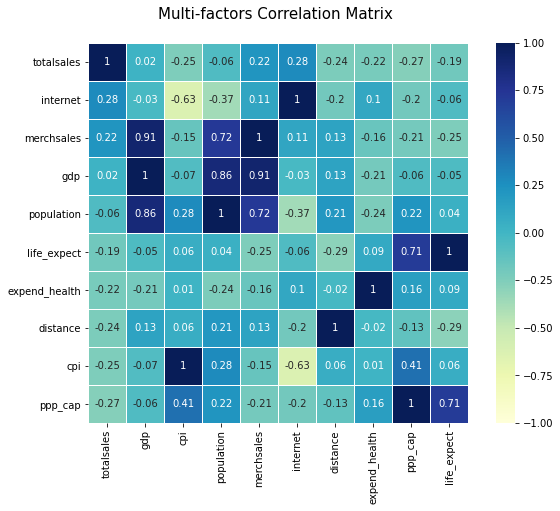

In [ ]:
# plotting correlation matrices for limited
def matrix(title,size,corr,rang,square=True,annot=True):
    fig = plt.figure()
    fig.set_size_inches(size[0], size[1])

    ax1 = plt.subplot()
    ax1 = sns.heatmap(corr,vmin=rang[0], vmax=rang[1], cmap="YlGnBu"
    ,center=(rang[0]+rang[1])/2,square=square,annot=annot,linewidths=.8)
    ax1.set_title(title,fontsize=15)

matrix(title="Multi-factors Correlation Matrix \n",size=(10,7),corr=corr,rang=(-1,1))

# cmap="YlGnBu"
# cmap=sns.diverging_palette(20, 220, n=25)

In [ ]:
# create a SPLOM OF all factors - pending visualization
import seaborn as sns
import altair as alt
## scatter plot or SPLOMS

# chart = alt.Chart(da).mark_point(fill='red',fillOpacity=0.6,size=70).encode(
#     x=alt.X('totalsales:Q',axis=alt.Axis(labelFontSize=12,titleFontSize=14,title="totalsales")),
#     y=alt.Y('expend_health:Q',axis=alt.Axis(labelFontSize=12,titleFontSize=14,title='expend_health'))
# )
# chart+chart.transform_regression('totalsales', 'expend_health').mark_line(line=True,fill='black',strokeDash=[1,5],stroke='black',opacity=0.6)

In [ ]:
### Now let's do something more interesting and build an interactive map - with a menu of all the indicators.
## These indicators have different measures, so we will normalize them in order to have consistency in the visualization
# Merged_df_norm is our final, normalized dataset
## SIADS 521 assignment 3 - last section. self reference.

liste_WBK=liste_factores.copy()
merged_df3=da.copy()
merged_df3.set_index("code",inplace=True)
df3=merged_df3[liste_WBK]
merged_df_norm = df3.apply(lambda x: (x - np.nanmean(x)) / np.nanstd(x))
# merged_df_norm[["Country",'code']]=merged_df[["Country",'code']]
df3.reset_index(inplace=True)
df3["Country"]=df3["code"].apply(lambda val:valeurs(val,value=False))
df1=df3
df1

code           gdp         cpi   population    merchsales   internet  \
0   AUS  1.015660e+12  103.303850   22340024.0  2.437010e+11  79.487698   
1   FRA  2.800855e+12  102.111598   65342789.0  7.200280e+11  77.819999   
2   USA  1.706195e+13  103.156842  311583481.0  2.266024e+12  69.729461   
3   BEL  5.315359e+11  103.532082   11038264.0  4.669430e+11  81.609996   
4   IRL  2.464671e+11  102.557189    4580084.0  6.660600e+10  74.889973   
5   DEU  3.988431e+12  102.075175   80274983.0  1.254869e+12  81.270000   
6   PRT  3.305025e+11  103.653011   10557560.0  8.289600e+10  55.249997   
7   JPN  4.808104e+12   99.732366  127833000.0  8.553800e+11  79.054114   
8   DNK  2.857325e+11  102.758682    5570572.0  9.566300e+10  89.810013   
9   NGA  8.232877e+11  110.840028  162805080.0  5.600000e+10  13.800000   
10  NLD  8.779594e+11  102.341070   16693074.0  5.943660e+11  91.419996   
11  POL  9.563117e+11  104.239401   38063255.0  2.105970e+11  61.949999   
12  ESP  1.724070e+12  103.196146   46742697.0  3.766060e+11  67.089999   
13  ITA  2.546921e+12  102.780633   59379449.0  5.587870e+11  54.389998   
14  CYP  3.196117e+10  103.289449    1124837.0  8.678000e+09  56.859892   
15  GRC  3.372864e+11  103.329864   11104899.0  6.670500e+10  51.649995   
16  NOR  3.029167e+11  101.284952    4953088.0  9.078400e+10  93.489983   
17  AUT  4.456210e+11  103.286579    8391643.0  1.914170e+11  78.739993   
18  SWE  4.625148e+11  102.961151    9449213.0  1.770260e+11  92.769986   
19  ARE  5.021243e+11  100.877347    8946778.0  2.299320e+11  78.000000   
20  FIN  2.523103e+11  103.416808    5388272.0  8.426400e+10  88.709995   
21  CHE  5.249244e+11  100.231349    7912398.0  2.082200e+11  85.193028   
22  MLT  1.368766e+10  102.962985     416268.0  6.293000e+09  68.019824   
23  BHR  5.644002e+10   99.599959    1278153.0  1.273000e+10  76.999966   
24  BMU  5.541488e+09         NaN      64564.0  9.000000e+08  88.336000   
25  HKG  3.781396e+11  105.276561    7071600.0  5.108550e+11  72.200000   
26  SGP  4.226694e+11  105.247793    5183688.0  3.657700e+11  71.000000   
27  THA  9.756729e+11  103.808791   67518379.0  2.287870e+11  23.669926   
28  ISR  2.775772e+11  103.478573    7765800.0  7.274700e+10  68.873878   
29  LTU  7.863586e+10  104.130276    3028115.0  3.177300e+10  63.639977   
30  LBN  9.741833e+10  104.971486    5202022.0  2.075000e+10  52.000000   
31  KOR  1.767207e+12  104.025846   49936638.0  5.244130e+11  83.759120   
32  BRA  3.026581e+12  106.636450  197514541.0  2.369640e+11  45.690000   
33  CAN  1.573517e+12  102.912135   34339328.0  4.636400e+11  83.000000   
34  ISL  1.537206e+10  104.001027     319014.0  4.841000e+09  94.819687   

     distance  expend_health       ppp_cap  life_expect               Country  
0   20225.200       4.508153  13905.245764    71.234000             Australia  
1    3224.950      13.095275   3765.150290    66.646000                France  
2    7767.240       4.465111  11393.574239    71.827000                   USA  
3     323.696       5.229733   1784.619497    57.761000               Belgium  
4     734.066       2.791318   9435.590356    68.848000                  EIRE  
5     540.242       5.334504  11970.344910          NaN               Germany  
6    1489.630            NaN   5450.513620    72.915000              Portugal  
7   20404.300       5.811701   3439.344814    61.851000                 Japan  
8    1384.200       5.267481  10901.880270    75.199000               Denmark  
9    7388.720      10.233579  52841.767452    81.204878               Nigeria  
10    270.419       5.078438   2434.377011    68.028000           Netherlands  
11   1788.870            NaN  33224.565519    78.640659                Poland  
12   2125.950       4.468978   1360.938538    62.505000                 Spain  
13   3520.150       8.299319  10820.501497    73.581000                 Italy  
14   5979.620      10.720538  49681.286396    80.436585                Cyprus  
15   4917.300         

In [ ]:
# let's set a new folium map with a high-level zoom
new_map = folium.Map(location=[0, 0], zoom_start=1.5)

In [ ]:
# Now we need to create feature groups with their corresponding data frames in order to draw the 4 
# different indicators on the map
data_frames=[]
liste_feat_groups=[]

j=0
for element in liste_WBK:
    df="{}".format(element)
    df=df1[["Country","code",element]]
    data_frames.append(df)   
    feat_group="feature_group{}".format(j)
    feat_group = folium.FeatureGroup(name=element,overlay=False).add_to(new_map)
    liste_feat_groups.append(feat_group)
    j+=1

In [ ]:
# let's incorporate  the  feature groups within the Choropeth object that's part of the map.
for i in range(len(data_frames)):
    
    choropleth = folium.Choropleth(
    geo_data=world_geo,
    name='choropleth',
    data=data_frames[i],
    columns=['code',liste_WBK[i]],
    key_on='feature.id',                     
    fill_color='YlGnBu',
    nan_fill_color="white",
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    legend_name=liste_WBK[i],   
    line_color='black').geojson.add_to(liste_feat_groups[i])
    
    # Let's add the country labels that are activated when the mouse
    geojson1 = folium.GeoJson(data=world_geo,style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5}, tooltip=folium.GeoJsonTooltip(fields=['name'],labels=False)).add_to(choropleth)

# Let's add a legend to the map   
colormap = cm.linear.YlGnBu_09.scale(-3,3)
colormap = colormap.to_step(10)
colormap.caption = "Data is normalized"
colormap.add_to(new_map)

# Let's display the menu
folium.LayerControl(collapsed=False).add_to(new_map)

# finally, let's draw the map, We are done!
new_map    

# You can now navigate on each country to see their country name and also use the menu on the right.

# Fitting regression model sales ~ macro data

In [ ]:
# Running the algorithm
dico={}
r=0
winner=[]

for i in range(1,len(liste_factores)):
    # Creating an itertool object with all combinations of factors
    liste=(itertools.combinations(liste_factores,i))
    
    for i in liste:
        # Creating a string with + to integrate factors into model
        element1=' + '.join(list(i))
        
        # Creating string with final parameters for linear regression
        a="totalsales ~ {}".format(element1)
        
        # Running the linear regression
        model = sm.OLS.from_formula(a, data=da)
        result = model.fit()
        
        # Creating a dictionary with all the combinations' adj r squared results
        dico[element1]=result.rsquared_adj.round(3)
        r1=dico[element1]
        
        # saves best adjusted r-squared and liste of columns 
        if r1>r:
            r=r1
            winner=element1
        
# Extracting second best model
second=sorted(dico.items(), key=lambda x: x[1],reverse=True)[:5][1][0]

# Running the winning model
a="totalsales ~ {}".format(winner)
model = sm.OLS.from_formula(a, data=da)
result = model.fit()

# Returns best model according to Adjusted R-squared
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalsales   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     4.146
Date:                Sat, 04 Sep 2021   Prob (F-statistic):            0.00994
Time:                        16:40:05   Log-Likelihood:                -386.11
No. Observations:                  31   AIC:                             782.2
Df Residuals:                      26   BIC:                             789.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      9.528e+04   3.81e+04      2.502      0.019     1.7e+04    1.74e+05
gdp           -2.996e-08   9.83e-09     -3.048      0.005   -5.02e-08   -9.76e-09
merchsales     2.194e-07   6.59e-08      3.327      0.003    8.39e-08    3.55e-07
distance         -3.6512      1.903     -1.919      0.066      -7.562       0.259
expend_health -7609.1502   4382.788     -1.736      0.094   -1.66e+04    1399.800
==============================================================================
Omnibus:                       15.540   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.704
Skew:                           1.481   Prob(JB):                     0.000236
Kurtosis:                       5.039   Cond. No.                     1.09e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# Returns Top 10 models according to adjusted R-squared
ordered_liste=sorted(dico.items(), key=lambda x: x[1],reverse=True)[:10]
ordered_liste

[('gdp + merchsales + distance + expend_health', 0.295),
 ('gdp + merchsales + internet + distance + expend_health', 0.272),
 ('gdp + cpi + merchsales + distance + expend_health', 0.271),
 ('gdp + merchsales + distance + expend_health + ppp_cap', 0.27),
 ('gdp + population + merchsales + distance + expend_health', 0.268),
 ('gdp + cpi + population + merchsales + distance + expend_health', 0.258),
 ('gdp + population + merchsales + internet + distance + expend_health',
  0.253),
 ('gdp + merchsales + distance', 0.25),
 ('gdp + population + merchsales + distance + expend_health + ppp_cap', 0.246),
 ('gdp + merchsales + internet + distance + expend_health + ppp_cap', 0.244)]

In [ ]:
# Running the second_best model
a="totalsales ~ {}".format(second)
model = sm.OLS.from_formula(a, data=da)
result_second = model.fit()

# Returns best model according to Adjusted R-squared
result_second.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalsales   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     3.244
Date:                Sat, 04 Sep 2021   Prob (F-statistic):             0.0215
Time:                        16:40:05   Log-Likelihood:                -386.00
No. Observations:                  31   AIC:                             784.0
Df Residuals:                      25   BIC:                             792.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7.434e+04   6.41e+04      1.159      0.257   -5.78e+04    2.06e+05
gdp           -2.862e-08   1.05e-08     -2.724      0.012   -5.03e-08   -6.98e-09
merchsales     2.096e-07   7.11e-08      2.948      0.007    6.32e-08    3.56e-07
internet        301.0100    734.892      0.410      0.686   -1212.529    1814.549
distance         -3.4441      1.999     -1.723      0.097      -7.561       0.673
expend_health -7726.0791   4463.800     -1.731      0.096   -1.69e+04    1467.290
==============================================================================
Omnibus:                       15.035   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.816
Skew:                           1.455   Prob(JB):                     0.000368
Kurtosis:                       4.942   Cond. No.                     1.81e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.81e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# showing winning model parameters
result.params

Intercept        9.528416e+04
gdp             -2.995532e-08
merchsales       2.193964e-07
distance        -3.651236e+00
expend_health   -7.609150e+03
dtype: float64

In [ ]:
len(da)

35

# Running predictions based on winning macro model

In [ ]:
# returning sales predictions dataset based on winning model
predictions=result.predict(da)
da["pred"]=predictions
da.loc[da["pred"]<0,"pred"]=0
da.loc[:,'potential']=da.loc[:,'pred']-da.loc[:,'totalsales']
df_predict=da[['name','totalsales','pred','potential']].copy()
df_predict.set_index("name",inplace=True)

df_predict=df_predict.fillna(0)
df_predict.loc[:,"potential"]=df_predict.loc[:,"potential"].fillna(0)
df_predict.loc[df_predict["potential"]<0,"potential"] =0

df_predict.sort_values('potential',ascending=False,inplace=True)

# returns df predict as integer
df_predict=df_predict.astype(int)
#df_predict
df_predict

/tmp/ipykernel_190/3002043064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da["pred"]=predictions
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/shared-libs/python3.9/py/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



totalsales    pred  potential
name                                               
Belgium                    36927  140831     103904
Hong Kong                   9952   88340      78387
Italy                      15820   65582      49762
Lithuania                   1661   50304      48643
Canada                      3115   50167      47052
Denmark                    18211   62577      44366
Malta                       2070   39527      37456
Israel                      8135   43004      34869
Korea                          0   29353      29353
Spain                      55725   84497      28772
Lebanon                     1693   28873      27179
Bermuda                        0   19375      19375
Austria                     8742   27851      19108
Iceland                     4310   22075      17765
Thailand                       0   16554      16554
USA                         3580   19009      15429
United Arab Emirates        1864   16978      15113
Switzerland                53087   61937       8850
Norway                     32454   39964       7509
Brazil                      1143    6139       4995
Germany                   205569  208559       2989
Cyprus                     13254       0          0
Singapore                   9120    5773          0
EIRE                      271164   78594          0
Portugal                   27015       0          0
Japan                      37416   20200          0
Netherlands               283889  159756          0
Nigeria                        0       0          0
Greece                      4425       0          0
Bahrain                      754       0          0
Poland                      6974       0          0
Finland                    18344   13487          0
Sweden                     36839       0          0
France                    184582   57936          0
Australia                 138171   10176          0

# Fitting regression model based on sales trend

In [ ]:
### Creating the data table by country (let's recreate it from above to be consistent)
import datetime as dt
df=row_df
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['month_year'] = df['InvoiceDate'].dt.to_period('M')
# df["Code"]=df["Country"].apply(lambda k:valeurs(k))
df2=df[['Country','month_year',"SalesValue"]]
df2.columns=["Country",'month_year',"sales"]
df2=df2.dropna(subset=['Country'])
# df2.set_index("Country",inplace=True)
df2=df2.groupby(["Country","month_year"])["sales"].sum()
df2=df2.reset_index()
table = pd.pivot_table(df2, values='sales', index=['Country'],
                    columns=['month_year'], aggfunc=np.sum, fill_value=0)
cols=['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
       '2010-12']
table.columns=cols
table=table.astype(int)
table["suma"]=table.apply(lambda row: row.sum(), axis=1)
table.sort_values("suma",ascending=False,inplace=True)
corr2=table.copy()
corr2=corr2[cols]

In [ ]:
# sales by month
corr2

2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  \
Country                                                                      
Netherlands              8754    26596    22831    22206     2886    28942   
EIRE                     9683    21704    12083    18323     7270    17758   
Germany                 13279    15326     8825    12862    10994    23518   
France                   8530    16174     7687    13689     3899    16174   
Australia                1032     9017    14695    17223      421    13638   
Spain                    1703     9694     1722     4775     1645     2697   
Switzerland              1224     4031     2374     1590     1756     3450   
Japan                    7705        0     5780       48     6548     1351   
Belgium                  1599     1080     1926     2994     1788     2486   
Sweden                   3834     3286      469     4680      649     2641   
Norway                   3787        0      590      345        0        0   
Portugal                 2047     3479     1017     2520     1687      602   
Channel Islands           313      675     1784     3509      243      914   
Finland                   652      769      165     4865     1368        0   
Denmark                  1137        0      363     3978        0      479   
Italy                     650     2066      228     1676      737      587   
Cyprus                   1590      547     3998      938        0        0   
Hong Kong                   0     2439        0        0     1539     1966   
Singapore                   0     2053        0        0     2118        0   
Austria                   157        0      438     1308      584     1049   
Israel                      0      379      779        0      110        0   
Poland                    248      613      604      317      705     1402   
Unspecified                 0        0        0        0      299     1055   
Greece                      0     2661        0      387      509        0   
Iceland                   711      475        0        0      636        0   
USA                         0        0        0        0      383        0   
Canada                      0        0        0      140        0      534   
Malta                       0        0        0        0        0        0   
United Arab Emirates        0        0      889        0        0        0   
Lebanon                     0     1693        0        0        0        0   
Lithuania                1661        0        0        0        0        0   
European Community          0        0        0        0      155        0   
Brazil                      0        0        0        0     1143        0   
RSA                         0        0        0        0        0        0   
Czech Republic              0        0      549        0        0        0   
Bahrain                   205        0        0        0        0      548   
Saudi Arabia                0        0      145        0        0        0   

                      2010-06  2010-07  2010-08  2010-09  2010-10  2010-11  \
Country                                                                      
Netherlands             26753       11    40327    26832    40378    25640   
EIRE                    20713    42289    18053    42486    23817    29838   
Germany                 12122    14743    17636    16561    28422    24252   
France                  14962     9171    12630    21898    24008    29216   
Australia               25187     4964    22489     5106    17150     7242   
Spain                    2717     7120     2898     4461     7964     8034   
Switzerland              7544     3518     4889     7524     7265     7916   
Japan                    1607     3854        0      112     1948     8460   
Belgium                  3848     2205     3140     3779     5169     5619   
Sweden                    675     6692     1160     4517     5671     2322   
Norway                   5186      770     

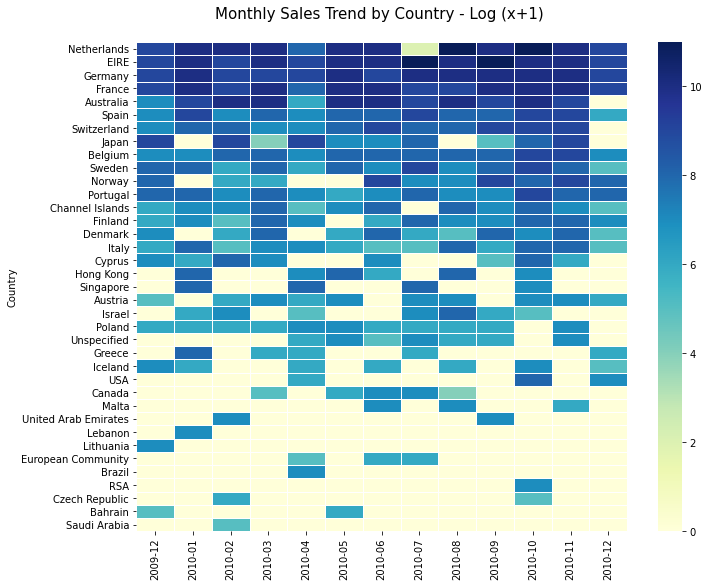

In [ ]:
# Monthly Sales visualization with heat map
# Transformation to log (x+1) as we have many 0s in the dataset

corr2=np.log(corr2+1).round(0)
maxi=corr.to_numpy().max()

matrix(title="Monthly Sales Trend by Country - Log (x+1) \n",size=(11,9),corr=corr2,rang=(0,maxi),square=False,annot=False)

In [ ]:
## add a count of existing sales value, will only make predictions on rows with at least 7 values.
table['count'] = table[table[cols] > 0].count(axis=1)
table_short=table[table['count']>=7].copy()

# convert negative values to zero
table_short[table_short < 0] = 0
table_short.astype(int)


2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  \
Country                                                                 
Netherlands         8754    26596    22831    22206     2886    28942   
EIRE                9683    21704    12083    18323     7270    17758   
Germany            13279    15326     8825    12862    10994    23518   
France              8530    16174     7687    13689     3899    16174   
Australia           1032     9017    14695    17223      421    13638   
Spain               1703     9694     1722     4775     1645     2697   
Switzerland         1224     4031     2374     1590     1756     3450   
Japan               7705        0     5780       48     6548     1351   
Belgium             1599     1080     1926     2994     1788     2486   
Sweden              3834     3286      469     4680      649     2641   
Norway              3787        0      590      345        0        0   
Portugal            2047     3479     1017     2520     1687      602   
Channel Islands      313      675     1784     3509      243      914   
Finland              652      769      165     4865     1368        0   
Denmark             1137        0      363     3978        0      479   
Italy                650     2066      228     1676      737      587   
Cyprus              1590      547     3998      938        0        0   
Austria              157        0      438     1308      584     1049   
Israel                 0      379      779        0      110        0   
Poland               248      613      604      317      705     1402   
Unspecified            0        0        0        0      299     1055   
Iceland              711      475        0        0      636        0   

                 2010-06  2010-07  2010-08  2010-09  2010-10  2010-11  \
Country                                                                 
Netherlands        26753       11    40327    26832    40378    25640   
EIRE               20713    42289    18053    42486    23817    29838   
Germany            12122    14743    17636    16561    28422    24252   
France             14962     9171    12630    21898    24008    29216   
Australia          25187     4964    22489     5106    17150     7242   
Spain               2717     7120     2898     4461     7964     8034   
Switzerland         7544     3518     4889     7524     7265     7916   
Japan               1607     3854        0      112     1948     8460   
Belgium             3848     2205     3140     3779     5169     5619   
Sweden               675     6692     1160     4517     5671     2322   
Norway              5186      770     1505     8398     3316     5807   
Portugal             800     2175     1221     1377     5330     2336   
Channel Islands     2060        0     4896     1323     2623     1464   
Finland              289     2436     1096      905     2266     2456   
Denmark             3063      358      195     4510     1274     2699   
Italy                202      147     1838      279     3329     3875   
Cyprus              1109        0        0      196     4412      460   
Austria                0     1111     1436        0      923     1209   
Israel                 0     1430     4873      423      138        0   
Poland               263      607      361      489        0     1361   
Unspecified          185     1425      531      286        0      965   
Iceland              382        0      584        0     1294        0   

                 2010-12    suma  count  
Country                                  
Netherlands        11728  283884     13  
EIRE                7140  271157     13  
Germany             7024  205564     13  
France              6538  184576     13  
Australia              0  138164     12  
Spain                288   55718     13  
Switzerland            0   53081     12  
Japan                  0   37413     10  
Belgium             1288   36921     13  
Sweden               238   36834     13  
Norway 

In [ ]:
cols_2010=cols[1:].copy()
table["2010_sales"]=table[cols_2010].sum()
cols_2011=['2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12']

def regression(row):
    my_x=list(range(1,14))
    my_y=row
    b1, b0, r_value, p_value, std_err = scipy.stats.linregress(my_x, my_y)

    y_hat=[]
    for x in range (13,25):
        y_hat.append(b0 + b1 * x)

    return y_hat

index1=table.index
table["month"]=table[cols].apply(lambda row: regression(row.tolist()),axis=1)
table5=table.copy()
table = pd.DataFrame([pd.Series(x).astype(int) for x in table.month],index=index1)
table.columns=cols_2011
table["2011_pred_sales"]=table.sum(axis=1).astype(int)


In [ ]:
table5

2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  \
Country                                                                      
Netherlands              8754    26596    22831    22206     2886    28942   
EIRE                     9683    21704    12083    18323     7270    17758   
Germany                 13279    15326     8825    12862    10994    23518   
France                   8530    16174     7687    13689     3899    16174   
Australia                1032     9017    14695    17223      421    13638   
Spain                    1703     9694     1722     4775     1645     2697   
Switzerland              1224     4031     2374     1590     1756     3450   
Japan                    7705        0     5780       48     6548     1351   
Belgium                  1599     1080     1926     2994     1788     2486   
Sweden                   3834     3286      469     4680      649     2641   
Norway                   3787        0      590      345        0        0   
Portugal                 2047     3479     1017     2520     1687      602   
Channel Islands           313      675     1784     3509      243      914   
Finland                   652      769      165     4865     1368        0   
Denmark                  1137        0      363     3978        0      479   
Italy                     650     2066      228     1676      737      587   
Cyprus                   1590      547     3998      938        0        0   
Hong Kong                   0     2439        0        0     1539     1966   
Singapore                   0     2053        0        0     2118        0   
Austria                   157        0      438     1308      584     1049   
Israel                      0      379      779        0      110        0   
Poland                    248      613      604      317      705     1402   
Unspecified                 0        0        0        0      299     1055   
Greece                      0     2661        0      387      509        0   
Iceland                   711      475        0        0      636        0   
USA                         0        0        0        0      383        0   
Canada                      0        0        0      140        0      534   
Malta                       0        0        0        0        0        0   
United Arab Emirates        0        0      889        0        0        0   
Lebanon                     0     1693        0        0        0        0   
Lithuania                1661        0        0        0        0        0   
European Community          0        0        0        0      155        0   
Brazil                      0        0        0        0     1143        0   
RSA                         0        0        0        0        0        0   
Czech Republic              0        0      549        0        0        0   
Bahrain                   205        0        0        0        0      548   
Saudi Arabia                0        0      145        0        0        0   

                      2010-06  2010-07  2010-08  2010-09  2010-10  2010-11  \
Country                                                                      
Netherlands             26753       11    40327    26832    40378    25640   
EIRE                    20713    42289    18053    42486    23817    29838   
Germany                 12122    14743    17636    16561    28422    24252   
France                  14962     9171    12630    21898    24008    29216   
Australia               25187     4964    22489     5106    17150     7242   
Spain                    2717     7120     2898     4461     7964     8034   
Switzerland              7544     3518     4889     7524     7265     7916   
Japan                    1607     3854        0      112     1948     8460   
Belgium                  3848     2205     3140     3779     5169     5619   
Sweden                    675     6692     1160     4517     5671     2322   
Norway                   5186      770     

# Final table with country ranking based on potential for both models: macro &amp; trend

In [ ]:
merged_potential=pd.merge(df_predict.reset_index(), table.reset_index(), how='left',left_on='name', right_on='Country')
merged_potential.round(0)
merged_potential["pot_regress"]=merged_potential["2011_pred_sales"]-merged_potential["totalsales"]
# merged_potential=merged_potential[[]]
# merged_potential=merged_potential.fillna(0)
#merged_potential[merged_potential < 0] = 0
#merged_potential.astype(int)
#merged_potential.columns=["2010_sales","Macro_predict","Macro_pot","Regress_predict","Regress_pot"]
#Top_country=merged_potential.loc[(merged_potential!=0).all(axis=1)]
#Top_country.astype(int).sort_values("Regress_pot",ascending=False)
merged_potential

name  totalsales    pred  potential               Country  \
0                Belgium       36927  140831     103904               Belgium   
1              Hong Kong        9952   88340      78387             Hong Kong   
2                  Italy       15820   65582      49762                 Italy   
3              Lithuania        1661   50304      48643             Lithuania   
4                 Canada        3115   50167      47052                Canada   
5                Denmark       18211   62577      44366               Denmark   
6                  Malta        2070   39527      37456                 Malta   
7                 Israel        8135   43004      34869                Israel   
8                  Korea           0   29353      29353                   NaN   
9                  Spain       55725   84497      28772                 Spain   
10               Lebanon        1693   28873      27179               Lebanon   
11               Bermuda           0   19375      19375                   NaN   
12               Austria        8742   27851      19108               Austria   
13               Iceland        4310   22075      17765               Iceland   
14              Thailand           0   16554      16554                   NaN   
15                   USA        3580   19009      15429                   USA   
16  United Arab Emirates        1864   16978      15113  United Arab Emirates   
17           Switzerland       53087   61937       8850           Switzerland   
18                Norway       32454   39964       7509                Norway   
19                Brazil        1143    6139       4995                Brazil   
20               Germany      205569  208559       2989               Germany   
21                Cyprus       13254       0          0                Cyprus   
22             Singapore        9120    5773          0             Singapore   
23                  EIRE      271164   78594          0                  EIRE   
24              Portugal       27015       0          0              Portugal   
25                 Japan       37416   20200          0                 Japan   
26           Netherlands      283889  159756          0           Netherlands   
27               Nigeria           0       0          0                   NaN   
28                Greece        4425       0          0                Greece   
29               Bahrain         754       0          0               Bahrain   
30                Poland        6974       0          0                Poland   
31               Finland       18344   13487          0               Finland   
32                Sweden       36839       0          0                Sweden   
33                France      184582   57936          0                France   
34             Australia      138171   10176          0             Australia   

    2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  \
0    4111.0   4323.0   4535.0   4747.0   4959.0   5171.0   5383.0   5595.0   
1     468.0    419.0    369.0    320.0    270.0    221.0    172.0    122.0   
2    1754.0   1844.0   1933.0   2023.0   2113.0   2202.0   2292.0   2382.0   
3    -200.0   -255.0   -310.0   -365.0   -419.0   -474.0   -529.0   -584.0   
4     251.0    253.0    255.0    257.0    259.0    261.0    263.0    265.0   
5    1831.0   1903.0   1975.0   2047.0   2119.0   2191.0   2263.0   2334.0   
6     277.0    297.0    317.0    337.0    356.0    376.0    396.0    416.0   
7     881.0    924.0    966.0   1009.0   1052.0   1094.0   1137.0   1180.0   
8       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
9    4752.0   4830.0   4908.0   4986.0   5064.0   5142.0   5219.0   5297.0   
10   -148.0   -195.0   -241.0   -288.0   -334.0   -381.0   -427.0   -474.0   
11      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
12    936.0    980.0   1024.0   1068.0   1112.0   1157.0   1201.0   1245.0   
13    323.0

# How to win: section on customer recommender system

In [ ]:
## need to clean and link to K's clean concatenate data set (UK and exports markets)
df = pd.read_excel ('data3.xlsx')


KeyboardInterrupt: 

In [ ]:
## cleaning stage stage 

df['sales']=df.apply(lambda row: row.Quantity * row.Price, axis=1)
import re
df.StockCode=df.StockCode.astype(str)
r = re.compile(r'[0-9]')
pattern = """\d+"""
df_clean=df[~df["Customer ID"].isnull()]
df_clean["Customer ID"].nunique()
df_clean=df_clean[df_clean["StockCode"].apply(lambda x: bool(re.match(pattern,x)))]
df_clean

df_copy=df.copy()
df_clean["Customer ID"]=df_clean["Customer ID"].astype(int)

In [ ]:
dfgroup=df_clean.groupby(["Country"]).agg({"Customer ID":pd.Series.nunique,"StockCode":pd.Series.nunique}).astype(int)
dfgroup

Customer ID  StockCode
Country                                     
Australia                      15        419
Austria                        10        361
Bahrain                         2         39
Belgium                        16        479
Brazil                          1         61
Canada                          1         77
Channel Islands                11        542
Cyprus                          7        416
Denmark                         9        284
EIRE                            3       2000
Finland                         6        224
France                         45       1275
Germany                        68       1457
Greece                          4        418
Iceland                         1         70
Israel                          2         73
Italy                          11        510
Japan                           6        136
Korea                           2         52
Lithuania                       1        113
Malta                           1        161
Netherlands                    22        877
Nigeria                         1         29
Norway                          4        217
Poland                          2        132
Portugal                       17        497
RSA                             1         65
Singapore                       1        110
Spain                          22        680
Sweden                         16        423
Switzerland                    14        673
Thailand                        1         76
USA                             5        157
United Arab Emirates            4        286
United Kingdom               3981       4004
Unspecified                     4        218
West Indies                     1         49

In [ ]:
## remove 4 index rows from index # this should go away with the right connections.
df_group2=df_clean.groupby(["Country","Customer ID"]).agg({"StockCode":pd.Series.nunique})
df_group2=df_group2.drop(["United Kingdom","Unspecified","Channel Islands","West Indies"])
df_group2

StockCode
Country              Customer ID           
Australia            12386                8
                     12387                9
                     12388               36
                     12389               41
                     12392                7
...                                     ...
USA                  12741               15
United Arab Emirates 12739               49
                     12742               67
                     12979               56
                     17829              121

[321 rows x 1 columns]

In [ ]:
# pivot table to return table matrix m= stockCode (stock codes) and n= Customer ID (columns including UK)
df_customers=df_clean.groupby(["Customer ID","StockCode"]).agg({"sales":"sum"})
table = pd.pivot_table(df_customers, values='sales', index=["StockCode"],columns=["Customer ID"],fill_value=0)
table

Customer ID  12346  12347  12348  12349  12351  12352  12353  12355  12356  \
StockCode                                                                    
10002          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10080          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10109          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10120          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10123C         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...            ...    ...    ...    ...    ...    ...    ...    ...    ...   
90214U         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214V         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214W         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214Y         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214Z         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Customer ID  12357  ...  18277  18278  18279  18280  18281  18283  18284  \
StockCode           ...                                                    
10002         10.2  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10080          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10109          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10120          0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10123C         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...            ...  ...    ...    ...    ...    ...    ...    ...    ...   
90214U         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214V         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214W         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214Y         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
90214Z         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

Customer ID  18285  18286  18287  
StockCode                         
10002          0.0    0.0    0.0  
10080          0.0    0.0    0.0  
10109          0.0    0.0    0.0  
10120          0.0    0.0    0.0  
10123C         0.0    0.0    0.0  
...            ...    ...    ...  
90214U         0.0    0.0    0.0  
90214V         0.0    0.0    0.0  
90214W         0.0    0.0    0.0  
90214Y         0.0    0.0    0.0  
90214Z         0.0    0.0    0.0  

[4020 rows x 4314 columns]

In [ ]:
# returning truncated matrix with m skus with k truncated customers SVD singular value decomposition from 4314 columns=> 200
from sklearn.decomposition import TruncatedSVD
X=table

# set the dimension reduction from n customers to k type of customers. 532
k=200
svd=TruncatedSVD(n_components=k,random_state=0)
svd.fit(X)
X_trunc=svd.fit_transform(X)
X_trunc

array([[ 6.07653585e+01,  1.53205780e+02, -7.70996452e+01, ...,
         2.02853092e+01, -3.20469052e+01,  4.65763946e+01],
       [ 8.87926856e-03,  4.98027736e-02, -2.22529230e-02, ...,
         5.40791717e-02, -5.25067632e-02,  4.76363118e-02],
       [ 1.37936517e-03,  5.44023739e-03, -3.50197838e-03, ...,
        -5.33621717e-03, -1.87114429e-02,  1.33060189e-02],
       ...,
       [ 3.97576130e-03,  2.14178841e-02, -1.16311211e-02, ...,
        -3.29665168e-02, -2.43522854e-02, -2.51635627e-02],
       [ 9.27007146e-03,  3.56249850e-02, -1.82657921e-02, ...,
        -1.35495990e-01, -2.89079852e-02, -2.81348024e-02],
       [ 2.15628675e-02,  7.61483241e-02, -3.99268936e-02, ...,
        -5.64064551e-02, -1.13617135e-01,  4.18388856e-02]])

In [ ]:
# returns size of truncated matrix
print(X_trunc.shape)

(4020, 200)


In [ ]:
# Calculating Sigma (midle component with singular values in diag, meaning the strength of the concept of group)
# k x k matrix - indicates the strength of the pattern (singular value)
singular_values=svd.singular_values_
Sigma_diag = np.diag(singular_values)
Sigma_diag.round(1)

array([[40684. ,     0. ,     0. , ...,     0. ,     0. ,     0. ],
       [    0. , 28685.4,     0. , ...,     0. ,     0. ,     0. ],
       [    0. ,     0. , 24615.1, ...,     0. ,     0. ,     0. ],
       ...,
       [    0. ,     0. ,     0. , ...,   849.3,     0. ,     0. ],
       [    0. ,     0. ,     0. , ...,     0. ,   845.2,     0. ],
       [    0. ,     0. ,     0. , ...,     0. ,     0. ,   839.9]])

In [ ]:
# set data frames for similarity function
# set X_truncated matrix for similarity function


# Calculating similarity based on cosine similarity n each row vs the truncated matrix
def cosine_similarity(vec_x, vec_y):
    return (vec_x@vec_y)/(np.linalg.norm(vec_x) * np.linalg.norm(vec_y))

def similarity_fun(row_customer,top_n):
    
    # convert to array the row corresponding to customers sales
    arr1=np.array(X[row_customer])
    
    # calculate similarity of customer array vs truncated matrix 
    similarity=np.array(df.apply(lambda row: cosine_similarity(arr1,row),axis=0))
    
    # returns index of array of maximum index
    ix_cos=np.argmax(similarity)
    
    # returns maximum similarity vs truncated matrix
    max_sim=similarity.max()
    
    # returns recommendation vs truncated matrix # change products that are missing only #
    reco_cosine=(X_trunc[:,ix_cos]-arr1).round(1).clip(min=0)
    reco=pd.DataFrame(reco_cosine,columns=["RECO Cosine"],index=X.index)
    # reco["RECO Cosine"]=reco_cosine
    reco["Current"]=arr1
    reco["Benchmark"]=X_trunc[:,ix_cos]
    
    # ranks in descending order the recommendation
    reco=reco.sort_values(by=["RECO Cosine"],ascending=False)
    
    # return top_n product recommendation
    top=reco.iloc[:top_n,]
    reco=list(top.index)
    return reco

similarity_fun.X_trunc=X_trunc
#convert X_trunc to df
df=pd.DataFrame(X_trunc)
similarity_fun.df=df

# set top_n to 5 meaning top 5 product recommendation
top_n=5
df_group1=df_group2.reset_index()
# returns product recommendation
df_group1["reco"]=df_group1["Customer ID"].apply(lambda x:similarity_fun(x,top_n))


In [ ]:
## returns the group_by table with the recomendation list in reco columns
df_group1.set_index(["Country", "Customer ID"],inplace=True)
df_group1=df_group1[["reco"]]
df_group1.head(2)

reco
Country   Customer ID                                      
Australia 12386        [22556, 22555, 21258, 21754, 35004C]
          12387        [22556, 22555, 21258, 21754, 35004C]

In [ ]:
## builds final recommendation matrix for top n products for each country by expanding the matrix
# converts list of reco to a data frame
final=df_group1["reco"].apply(lambda x:pd.Series(x))
#rename columns
final.columns=["Product "+str(i) for i in range(1,top_n+1)]
final.head(10)

Product 1 Product 2 Product 3 Product 4 Product 5
Country   Customer ID                                                  
Australia 12386           22556     22555     21258     21754    35004C
          12387           22556     22555     21258     21754    35004C
          12388           22086     71477     21523     62018     22114
          12389           84945    85232B     21210     21523     22492
          12392          84327A     84270     16033     20981     21680
          12393           20727     20726     20728     22622     71477
          12400           72741     20726     20728     47566     21621
          12411           22622     22659     71477     79321     21791
          12415           22423     84347    85123A     84879    85099B
          12416           85152     21485     48187     21769     22083

In [ ]:
## example of recommender system with Australia  ### Select top 5/10 key markets from potential. extract reco from the matrix.
final=final.loc["Australia"]
final

Product 1 Product 2 Product 3 Product 4 Product 5
Customer ID                                                  
12386           22556     22555     21258     21754    35004C
12387           22556     22555     21258     21754    35004C
12388           22086     71477     21523     62018     22114
12389           84945    85232B     21210     21523     22492
12392          84327A     84270     16033     20981     21680
12393           20727     20726     20728     22622     71477
12400           72741     20726     20728     47566     21621
12411           22622     22659     71477     79321     21791
12415           22423     84347    85123A     84879    85099B
12416           85152     21485     48187     21769     22083
12422          75049L     22158     85048     22236     21340
12424           22236     22158     21844     82484     21258
12431           48138     72741     22111     84949    84078A
12434           48138     72741     22111     84949    84078A
16321           85048     22946     22139     22585     22947

In [ ]:
# reload data frame if necessary (long)
df = df_copy

In [ ]:
 # return the value description according to key
def key(x):
    try:
        # convert key to int and returns
        x=int(x)
        return dict_products[x]
    except:
        # returns with string
        try:
            return dict_products[x]
        except:
            return "na"

# returns top 10 of most recommended products in data frame
def top_n_product(df):
    df2=df.apply(pd.value_counts).sum(axis=1).sort_values(ascending=False).astype(int)
    df2=df2.to_frame().reset_index()
    df2.columns=["code","count"]       
    ## returns top 15 most recommended products
    df2['description']=df2['code'].apply(lambda x: key(x))
    
    # returns top_n including ties
    df2=df2.set_index("code")[["description","count"]]
    return df2


## establish a dictionary with keys= code and values = description
dict_products=df.set_index('StockCode').to_dict()['Description']


key.dict_products=dict_products
df5=top_n_product(final)
df5.reset_index(inplace=True)

In [ ]:
# returns top_n
top_n=5
try:
    liste=list(df5["count"].unique())[:top_n]
except:
    liste=list(df5["count"].unique())
df5=df5[df5["count"].isin(liste)]
df5=df5.groupby(["count","description"]).agg({"code":min}).sort_values(by="count",ascending=False)
df5

code
count description                               
3     na                                   21258
2     SET OF 3 COLOURED  FLYING DUCKS     35004C
      SET/4 WHITE RETRO STORAGE CUBES     84078A
      na                                   20726
1     JUMBO BAG RED RETROSPOT             85099B
      LARGE CIRCULAR MIRROR MOBILE        75049L
      SET OF 3 BABUSHKA STACKING TINS     85232B
      WHITE HANGING HEART T-LIGHT HOLDER  85123A
      na                                   16033

# 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=023a0e03-cc30-4d6d-b448-6d27799cca93' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>